In [ ]:
!pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeRegressor as DT

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/metrics.ipynb
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/helpers.ipynb 
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/Decision_Tree_regressor.ipynb

cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/metrics.ipynb'
Try 'cp --help' for more information.
cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/helpers.ipynb'
Try 'cp --help' for more information.
cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/Decision_Tree_regressor.ipynb'
Try 'cp --help' for more information.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
#import import_ipynb
import itertools


In [ ]:

class Scaling():

  """
  Applies Standard Scaler and Min Max Scaler.
  ;minmax: when True runs Min Max Scaler
  """
  def __init__(self):
    self.__means = {}
    self.__vars  = {}
    self.__mins = {}
    self.__maxs = {}
  def fit(self, dffff, minmax = None):
      if minmax:
        for column in dffff.columns:
          min_one =(dffff[column]).min(axis=0)
          max_one = (dffff[column]).max(axis=0)
          final_col_train = (dffff[column] - min_one)/(max_one-min_one)
          dffff[column] = final_col_train
          self.__mins[column] = min_one
          self.__maxs[column] = max_one
      else:
        for column in dffff.columns:
          mean_one = np.mean(np.array(dffff[column]), 0)
          final_col_train = (dffff[column] - mean_one)
          stdd = np.std(final_col_train, ddof=0)
          final_col_train =  final_col_train/stdd

          dffff[column] = final_col_train

          self.__means[column] = mean_one
          self.__vars[column] = stdd
      return dffff

  def transform(self, df, minmax = None):
      if minmax:
        for column in df.columns:
          final_col_test = ( df[column].values - self.__mins[column])/(self.__maxs[column] - self.__mins[column]) 
          df[column] = final_col_test
      else:
        for column in df.columns:
          final_col_test = ( df[column].values - self.__means[column])/self.__vars[column] 
          df[column] = final_col_test
      
      return df


In [ ]:
class PCA():

  """
  Applies PCA to train and test set.
  Draws PVE plot to chose suitable percentage of PC to pick.
  """
  def __init__(self):
    self.__eigenvectors = []
    self.__pve_list = []
    self.__pca = 0
    self.__number_of_components = 0
  def get_PCA_plot(self, df, threshold):
    df = self.__pve_list
    self.__number_of_components = [x+1 for x in range(len(df))]
    return self.__number_of_components, self.__pve_list

  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self, X_train, threshold):
    
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    
    return df_PCA
  
  def preprocess_test(self,X_test,X_train):
   
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  

    return df_PCA


In [ ]:
def traintest_split(path, scaler_is = None, pca_is = None):

        df_original = pd.read_csv(path, parse_dates = True, index_col = 0) 
        trainn = df_original.loc[:"2017-11-30 23:00:00"]
        val = df_original.loc["2017-12-01 00:00:00":"2017-12-31 23:00:00"]
        test = df_original.loc["2018-01-01 00:00:00":]
        scaler = Scaling()
        
        if scaler_is:
          trainn = scaler.fit(trainn, minmax = False)
          test = scaler.transform(test, minmax = False)
          val = scaler.transform(val, minmax = False)
        else: 
          trainn = scaler.fit(trainn, minmax = True)
          test = scaler.transform(test, minmax = True)
          val = scaler.transform(val, minmax = True)

        Y_train = pd.DataFrame(trainn.iloc[:, -1])
        Y_test = pd.DataFrame(test.iloc[:, -1])
        Y_val = pd.DataFrame(val.iloc[:, -1])

        X_train = pd.DataFrame(trainn.iloc[:, :-1])
        X_test = pd.DataFrame(test.iloc[:, :-1])
        X_val = pd.DataFrame(val.iloc[:, :-1])
        if pca_is :
          pca_comp = PCA()
          X_train = pca_comp.preprocess_train(np.array(X_train),95)
          X_test = pca_comp.preprocess_test(np.array(X_test), np.array(X_train))
          X_val = pca_comp.preprocess_test(np.array(X_val), np.array(X_train))

        return Y_train,Y_val, Y_test,X_train,X_val,X_test

In [ ]:
Y_train,Y_val, Y_test,X_train,X_val,X_test  = traintest_split("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv", scaler_is = False, pca_is = False)


In [ ]:
class DecisionTree():
  def __init__(self,max_depth=2):
    self.__root = None
    self.__max_depth = max_depth
    self.__min_samples_split = 3

  def SDR(self, parent, l_child, r_child):
    weight_l = len(l_child) / len(parent)
    weight_r = len(r_child) / len(parent)
    
    gain = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
    return gain

  def split(self, dataset, feature_index, threshold): 
    dataset_right = dataset[dataset[:,feature_index]>threshold]
    dataset_left = dataset[dataset[:,feature_index]<=threshold]
    return dataset_left, dataset_right

  def best_split(self, dataset, num_features):
    best_split = {}
    max_sdr = -float("inf")
    for feature_index in range(num_features):
      feature_values = dataset[:,feature_index]
      possible_thresholds = np.unique(feature_values)
      for threshold in possible_thresholds:
        dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
        if len(dataset_left)>0 and len(dataset_right)>0:
          y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
          curr_sdr = self.SDR(y, left_y, right_y)
          if curr_sdr>max_sdr:
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["dataset_left"] = dataset_left
            best_split["dataset_right"] = dataset_right
            best_split["SDR"] = curr_sdr
            max_sdr = curr_sdr
    return best_split

  def tree_itself(self, dataset, curr_depth=0):
    X, Y = dataset[:,:-1], dataset[:,-1]
    num_samples, num_features = np.shape(X)
    best_split = {}
    if num_samples>=self.__min_samples_split and curr_depth<=self.__max_depth:
        best_split = self.best_split(dataset, num_features)
        if best_split["SDR"]>0:
            left_subtree = self.tree_itself(best_split["dataset_left"], curr_depth+1)
            right_subtree = self.tree_itself(best_split["dataset_right"], curr_depth+1)
            return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["SDR"])
    
    leaf_value = np.mean(Y)
    
    return Node(value=leaf_value)

  def make_prediction(self, x, tree): 
    print("pred")    
    if tree.value!=None: 
      return tree.value
    feature_val = x[tree.feature_index]
    print(feature_val)
    print(tree.threshold)
    if feature_val<=tree.threshold:
        return self.make_prediction(x, tree.left)
    else:
        return self.make_prediction(x, tree.right)
    
  def predict(self, X):
    preditions = [self.make_prediction(x, self.__root) for x in X]
    return preditions

  def fit(self, X, Y):
    dataset = np.concatenate((X, Y), axis = 1)
    self.__root = self.tree_itself(dataset)

  def get_root(self):
    return self.__root

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, SDR=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.SDR = SDR
        self.value = value

In [ ]:
def median(fitt, m_weights):
    
    sorted_indices = fitt.argsort()
    fitt = fitt[sorted_indices]
    weights_cumsum = (m_weights[sorted_indices]).cumsum()
    median_res = fitt[np.argmax(weights_cumsum >= sum(m_weights)/2)]
    return median_res

In [ ]:

class AdaBoostR2():
    def __init__(self, X_train, T = 5, max_depth = 2, lr = 1, random_state = 42):
       
        self.X_train = X_train
        self.T = T
        self.lr = lr
        self.max_depth = max_depth
        self.N, self.D = X_train.shape
        self.weights = np.ones( self.N)/ self.N
        np.random.seed(random_state)
        self.best_model = {"T":self.T,
                           "max_depth":self.max_depth,
                           "lr":lr}
        self.trees = []    
        self.fitted = np.empty((self.N, self.T))
        self.betas = []
        self.model_weights = np.array([])

    def fit(self, X_train, Y_train):
        self.T = self.best_model["T"]
        self.max_depth = self.best_model["max_depth"]
        self.lr = self.best_model["lr"]
        losses =[]
        for t in range(self.T):
            bootstrap_idx = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights.reshape(-1))
            bootstrap_X,bootstrap_y = X_train[bootstrap_idx],Y_train[bootstrap_idx]
            tree = DecisionTree(max_depth = self.max_depth)
            tree.fit(bootstrap_X, bootstrap_y)

            self.trees.append(tree)
            yhat = np.array(tree.predict(X_train))
            self.fitted[:,t] = yhat
            abs_errors_t = np.abs(Y_train - yhat.reshape(-1,1))
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t            
            Lbar_t = np.sum(self.weights.reshape(-1,1)*L_ts)
            losses.append(np.mean(Lbar_t))
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted = self.fitted[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            beta_t = self.lr * Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            Z_t = np.sum(self.weights.reshape(-1,1)  * beta_t**(1-L_ts))
            self.weights  = self.weights.reshape(-1,1) * beta_t**(1-L_ts)/Z_t
            
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([median(self.fitted[n], self.model_weights) for n in range(self.N)])
        plt.plot(np.arange(len(losses)),  losses)
        plt.title("Training Loss versus Iteration")
        plt.xlabel("iteration number")
        plt.ylabel("Training Mean Absolute Error")
        plt.show()

    def predict(self, X_test):
        N_test = len(X_test)
        fitted = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted[:,t] = tree.predict(X_test)
        return np.array([median(fitted[n], self.model_weights) for n in range(N_test)])

    
    def search(self, parameters, X_train, Y_train, X_val, Y_val, refit =  None):
      """
      takes 1 hour with 15 paramaters.
      parameter search for n_estimators,max_depth
      """
      param_values = [v for v in parameters.values()] 
      error_of_choice= []
      whole_turns = []
      for n_estimators, max_depth,lr in itertools.product(*param_values):
          model = AdaBoostR2(X_train, n_estimators, max_depth, lr)
          model.fit(X_train,Y_train)
          y_pred_val = model.predict(X_val)
          MSE = mse(pd.DataFrame(Y_val),y_pred_val)
          error_of_choice.append(MSE)
          whole_turns.append([n_estimators,max_depth,lr]) 
          print('n_estimators: %.4f, max_depth: %.4f, learning rate: %.4f, MSE:%.7f' % (n_estimators,max_depth,lr,MSE))
      min_error_index =error_of_choice.index(min(error_of_choice))
      choice = whole_turns[min_error_index]
      print('Best parametres','n_estimators:',choice[0],'max_depth:',choice[1],'learning rate:',choice[2], 'MSE:',min(error_of_choice))
      self.best_model = {"T":choice[0],
                           "max_depth":choice[1],
                          "lr":choice[2]} 
      if refit:
        #print("ok")
        model = AdaBoostR2(X_train, choice[0], choice[1], choice[2])

        model.fit(X_train,Y_train)
        #print("refit",self.model_weights)
      return choice

    def plot_best(self,yhat, y):
      
      plt.plot( y.index, y)
      plt.plot( y.index, yhat)
      plt.legend(["Ground Truth",  "Prediction"])
      plt.title("The Plot of Predictions and Ground Truth versus Date")
      plt.xlabel("Date")
      plt.ylabel("Energy Demand (kWh)")
      plt.show()
      return None

    def evaluation(self,X_test,X_train,  Y_test, Y_train):
       
       model = AdaBoostR2(X_train, self.best_model["T"], self.best_model["max_depth"], self.best_model["lr"])
       model.fit(np.array(X_train),np.array(Y_train))
       y_pred = model.predict(X_test)
       y_pred_train = model.predict(X_train)
       print("MSE", mse(Y_test, y_pred),"MAE", mae(Y_test, y_pred),"R2 score", r2(Y_test, y_pred))
       print("Train MSE", mse(Y_train, y_pred_train),"MAE", mae(Y_train, y_pred_train),"R2 score", r2(Y_train, y_pred_train))
       return y_pred_train, y_pred

In [ ]:
#X_train = X_train.drop(columns = ["Unnamed: 0"])


In [ ]:
#X_test = X_test.drop(columns = ["Unnamed: 0"])

In [ ]:
#Y_train = pd.DataFrame(Y_train, index = X_train.index)

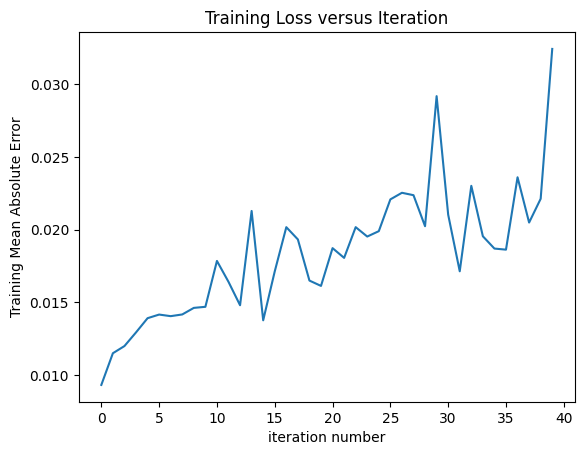

MSE 0.00023824708500083086 MAE 0.008946518313171553 R2 score 0.9814380014802249
Train MSE 8.133180395995527e-05 MAE 0.006835436876743605 R2 score 0.9935247685241321


In [ ]:
model = AdaBoostR2(X_train, 40,11, 0.75)
model.fit(np.array(X_train),np.array(Y_train))
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("MSE", mse(Y_test, y_pred),"MAE", mae(Y_test, y_pred),"R2 score", r2(Y_test, y_pred))
print("Train MSE", mse(Y_train, y_pred_train),"MAE", mae(Y_train, y_pred_train),"R2 score", r2(Y_train, y_pred_train))

n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.1000, MSE:0.0011391
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.5000, MSE:0.0010032
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.7500, MSE:0.0010635
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 1.0000, MSE:0.0010239
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.1000, MSE:0.0005863
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.5000, MSE:0.0004853
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.7500, MSE:0.0005340
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 1.0000, MSE:0.0005048
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.1000, MSE:0.0003404
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.5000, MSE:0.0002976
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.7500, MSE:0.0002782
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 1.0000, MSE:0.0002669
n_estimators: 10.0000, max_depth: 11.0000, learning 

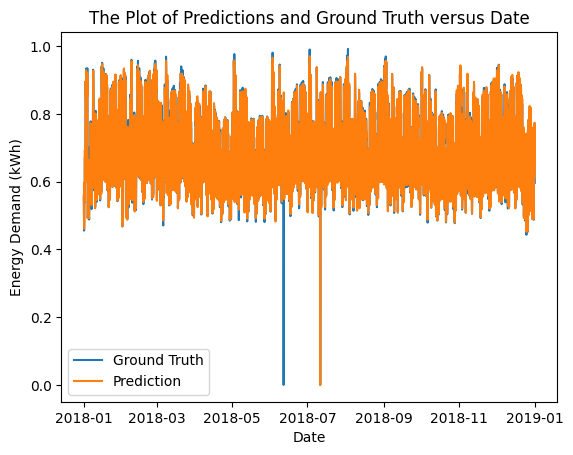

MSE 0.01028173247457163 MAE 0.08134120293900683 R2 score 0.1989429672431995
Train MSE 0.009271643649059703 MAE 0.07727284214474923 R2 score 0.26183810186994394


In [ ]:
param = {"n_estimators": [10,15,25],
              "max_depth":[5,7,9,11],
              "learning rate": [0.1,0.5,0.75,1],
}
model = AdaBoostR2(X_train, 15,5,1)
best_params = model.search(param,  np.array(X_train), np.array(Y_train), np.array(X_val), np.array(Y_val), refit = False)

model = AdaBoostR2(X_train,best_params[0],best_params[1], best_params[2] )
model.fit(np.array(X_train),np.array(Y_train))
y_pred_test = model.predict(X_test)
model.plot_best(y_pred_test, Y_test)
y_pred_train, y_pred = model.evaluation(X_test, X_train, Y_test, Y_train)



In [ ]:
booster = AdaBoostR2(X_train,T = 15, max_depth = 7,lr =1, random_state = 42,)
booster.fit(np.array(X_train), np.array(Y_train), )



In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = AdaBoostRegressor(estimator = DT(max_depth =11), n_estimators = 40,learning_rate=0.75)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
pred_train = model.predict(X_train)

print(mean_squared_error(Y_train,pd.DataFrame(pred_train)))
print(r2_score(Y_train,pd.DataFrame(pred_train)))
print(mean_absolute_error(Y_train,pd.DataFrame(pred_train)))

7.32153559034475e-05
0.9941709595265305
0.006414667707297608


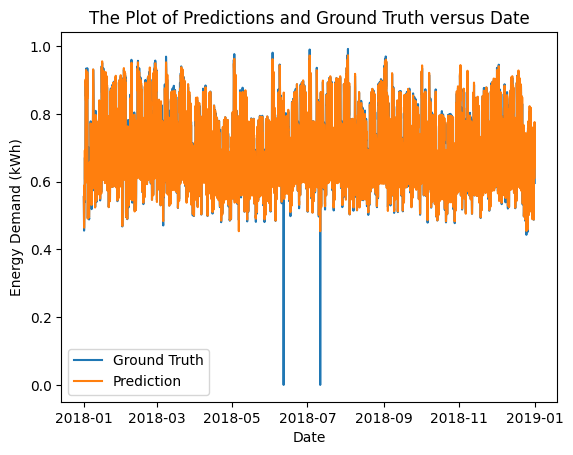

In [ ]:
MODEL = AdaBoostR2(X_train)
MODEL.plot_best(pred,Y_test)